In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import pickle

from sklearn.metrics import mean_squared_error

In [6]:
import mlflow

mlflow.set_tracking_uri("sqlite:///../../mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [11]:
df = pd.read_parquet("../data/green_tripdata_2021-01.parquet")

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
df[categorical] = df[categorical].astype(str)

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


9.827368941909366

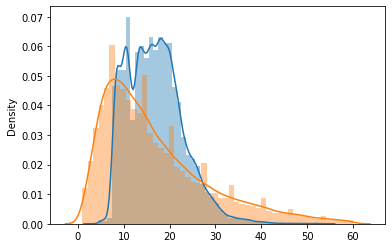

In [12]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

sns.distplot(y_pred, label="pred", bins=50)
sns.distplot(y_train, label="actual", bins=50)

mean_squared_error(y_pred, y_train, squared=False)

In [14]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [16]:
df_train = read_dataframe("../data/green_tripdata_2021-01.parquet")
df_val = read_dataframe("../data/green_tripdata_2021-02.parquet")

In [17]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [18]:
categorical = ['PU_DO']  # ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()
train_dicts = df_train[categorical + numerical].to_dict(orient='records')

X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [19]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [20]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_val = lr.predict(X_val)

display(mean_squared_error(y_pred_train, y_train, squared=False))
display(mean_squared_error(y_pred_val, y_val, squared=False))

5.699564118198959

7.758715206462274

In [21]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [25]:
with mlflow.start_run():
    mlflow.set_tag("developer", "Jaka")
    mlflow.log_param("train-data-path", "../data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "../data/green_tripdata_2021-02.parquet")

    alpha = 0.0001
    mlflow.log_param("alpha", alpha)
    
    lr_lasso = Lasso(alpha)
    lr_lasso.fit(X_train, y_train)

    y_pred_val = lr_lasso.predict(X_val)

    rmse = mean_squared_error(y_pred_val, y_val, squared=False)
    mlflow.log_metric("rmse", rmse)

In [26]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)

        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )

        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
    
    return  {'loss': rmse, 'status': STATUS_OK}

In [27]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

In [28]:
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials())

[10:06:50] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:6.78815                           
[1]	validation-rmse:6.70741                           
[2]	validation-rmse:6.68432                           
[3]	validation-rmse:6.65752                           
[4]	validation-rmse:6.64777                           
[5]	validation-rmse:6.63634                           
[6]	validation-rmse:6.63030                           
[7]	validation-rmse:6.62394                           
[8]	validation-rmse:6.61475                           
[9]	validation-rmse:6.61082                           
[10]	validation-rmse:6.60359                          
[11]	validation-rmse:6.59250                          
[12]	validation-rmse:6.58926                          
[13]	validation-rmse:6.58792                          
[14]	validation-rmse:6.58368                          
[15]	validation-rmse:6.58105                          
[